## Linear Regression - Predicting Trading Revenue Increase

The prediction model being created is very simple. The administrator has assumed that since revenue is a function of flow, trading revenue increases accordingly. Similarly costs would  increase in proportion to flow but given that this is a revenue exercise only revenue will be the focus of this analysis.

In [343]:
#import the necessary libraries

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
from sklearn import linear_model, metrics

import statsmodels.formula.api as smf

## The Query

The data for this exercise was first run in SQL. The requestor had a number of requirements that were well within the capabilities of SQL and therefore much of the filtering and aggregation was done in SQL rather than in Pandas. The code has been inserted into this analysis for future reference.

### A few things to know about the query:

-Data was pulled exclusively from AIB which comprises 75%-80% of the total EA (CID:7348) processing volume

-The data was pulled between 1/1/2016 through the present

-The data is restricted to three transaction currencies (CHF, EUR, and THB)

-The data where the three transaction currencies is EUR is restricted to where the issuer country is Italy

-The data flows in at the transactional level but is aggregated 

-The revenue is generated by joining the GM calculation table to the AIB cost table on month, year, transaction currency, and product code

The data was exported from SQL to the administrators desktop and a pandas "read_csv" function was written to pull the data into a useful dataframe.

In [340]:
df=pd.read_csv('d:\djohnson\Desktop\ea_trading_rev.csv')

The data is then quickly analyzed to ensure all the required elements are available

In [345]:
df.head()
list1=list(df)
df.head()

,ISSUER_COUNTRY,CLEARING_COUNTRY_NAME,TRANSACTION_CURRENCY,CONTRACT_ID,TRADING_MERCHANT_NAME,PRODUCT_CODE,STATUSMONTH,STATUSYEAR,VOL,FLOW,IC,SF,ACQ,INV_TARIFF_FIXED,INV_TARIFF_PERC,REVENUE
0,Italy,Switzerland,EUR,7348,origin com EA,100440,10,2016,3,83.7900,-0.50,-0.05,-0.0500,NaN,0.01455,1.219145
1,Italy,Switzerland,EUR,7348,origin com EA,100450,8,2016,3,34.7000,-0.42,-0.10,-0.0200,NaN,0.01804,0.625988
2,Thailand,Switzerland,THB,7348,origin com EA,100809,12,2016,3,73.0967,-1.25,-0.51,-0.0500,NaN,0.03478,2.542303
3,Thailand,Switzerland,THB,7348,origin com EA,100819,7,2017,5,144.1469,-2.57,-1.20,-0.0995,NaN,0.03639,5.245506
4,Italy,Switzerland,EUR,7348,origin com EA,100440,1,2017,1,23.9900,-0.14,-0.01,-0.0100,NaN,0.01397,0.335140


Let's have a look at just a few descriptive elements of the data

In [350]:
df[['VOL','FLOW','IC','SF','ACQ','REVENUE']].describe()

,VOL,FLOW,IC,SF,ACQ,REVENUE
count,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000
mean,56.383721,1184.533240,-12.202674,-6.480114,-0.755988,24.484405
std,128.308651,2691.503046,27.088500,16.235736,1.806570,53.707277
min,1.000000,3.790700,-172.800000,-105.139800,-12.998200,0.103979
25%,1.000000,23.185850,-7.965000,-4.365000,-0.285000,0.487857
50%,3.000000,75.423350,-0.790000,-0.355000,-0.045000,1.840164
75%,21.000000,504.269225,-0.270000,-0.100000,-0.010000,13.777172
max,776.000000,18521.710000,-0.050000,-0.010000,0.000000,362.469865


A working copy of the dataframe is created to allow the original dataset to remain in memory in case it needs to be pulled down again.

In [231]:
df2=df.copy()

The data is then broken into the features that predict the target. In this case the features are the transaction currency and the flow. The revenue is the target

In [232]:
df2=df2[['TRANSACTION_CURRENCY','VOL','FLOW','REVENUE']]
df2.head()

,TRANSACTION_CURRENCY,VOL,FLOW,REVENUE
0,EUR,3,83.7900,1.219145
1,EUR,3,34.7000,0.625988
2,THB,3,73.0967,2.542303
3,THB,5,144.1469,5.245506
4,EUR,1,23.9900,0.335140


The administrator suspects that the currency type my drive the regression and therefore has converted them into dummy variables.
This is done via the "get_dummies" function. Simply enter into the function the desired series and provide a prefix for these dummies. Also the series is best "dropped" from the original dataset and rejoined in its dummy format.

In [233]:
df2_curr=pd.get_dummies(df['TRANSACTION_CURRENCY'], prefix_sep='currency')
df2_curr.head()
df2=df2.drop(['TRANSACTION_CURRENCY','VOL'], axis=1)

Evaluate the dummies table

In [234]:
df2_curr.head()

,EUR,THB
0,1.0,0.0
1,1.0,0.0
2,0.0,1.0
3,0.0,1.0
4,1.0,0.0


Evaluate the X,y features and targets exluding the dummies

In [235]:
df2.head()

,FLOW,REVENUE
0,83.7900,1.219145
1,34.7000,0.625988
2,73.0967,2.542303
3,144.1469,5.245506
4,23.9900,0.335140


rejoin the datasets accoridngly

In [236]:
df3=df2.join(df2_curr)

Evaluate the rejoined tables

In [237]:
df3.head()

,FLOW,REVENUE,EUR,THB
0,83.7900,1.219145,1.0,0.0
1,34.7000,0.625988,1.0,0.0
2,73.0967,2.542303,0.0,1.0
3,144.1469,5.245506,0.0,1.0
4,23.9900,0.335140,1.0,0.0


Now that the information is assembled, the administrator can run a correlation function to observe collinearity of the individual features. What is observed is that the currencies are not as strong as predictors as the administrator originally assumed. However the correlation between revenue and flow are very strong.

In [238]:
corr_matrix=df3.corr()

In [239]:
corr_matrix['REVENUE']

FLOW       0.979240
REVENUE    1.000000
EUR        0.285625
THB       -0.285625
Name: REVENUE, dtype: float64

## Graphical Representation of the Feature and Predictor Relationship

Let's have a look at the datapoints for the query graphically. One can see that the revenue and the flow are very correlated. This was established in the correlation function above.

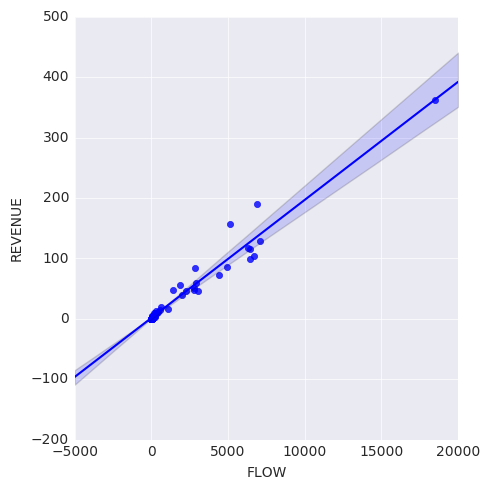

In [240]:
sns.lmplot('FLOW','REVENUE',df3)
plt.show()

To get a closer look at the data points we can take the log which converts everything to a base 10 format which provides us with 
a condensed scale that provides us with a better view of the individual data points. From the looks of the line at a closer range the flow and revenue are highly positively correlated.

In [336]:
log_columns=['FLOW','REVENUE']
log_df3 = df3.copy()
log_df3[log_columns] = log_df3[log_columns].apply(np.log10)

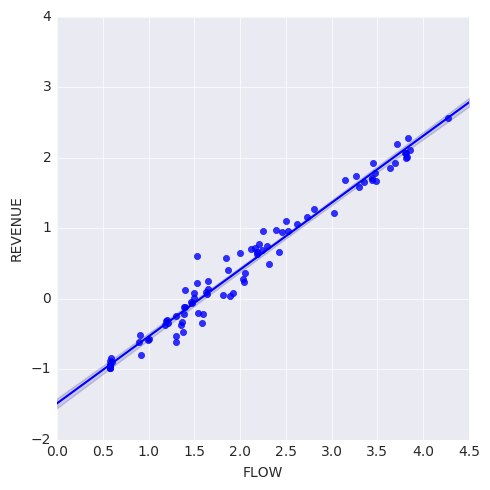

In [337]:
sns.lmplot('FLOW', 'REVENUE', log_df3)
plt.show()

## Create the  Linear Regression Predictor

Since the premise of this exercise is to predict a relationship between the flow feature and the target revenue we will use the scikit learn libraries to generate a linear regression model that we will fit to the data points and build a predictor model to guess what the potential revenue is if our flow increases to 750k.

In [358]:
X=df3[['FLOW']]
y=df3[['REVENUE']]

In [359]:
model = sklearn.linear_model.LinearRegression()

In [360]:
model.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [361]:
print model.predict(750000)

[[ 14656.43302986]]


### At a flow amount of 750k our model is predicting a trading revenue amount of 14.6k